# Camera Model Identification 
### Heather Holcomb 

#### Project Description: 
This project was taken from Kaggle - IEEE's Signal Processing Society - Camera Model Identification. The purpose of this project is to analyze images to identify the camera that the image was taken from. The objective is to build an algorithm that identifies which camera model captured an image by using traces intrinsically left in the image. This solution would address problems that investigators may face with possible fake images or videos submitted into evidence. It is possible for someone to take images from several different sources and make a video from them. An algorithm to classify the images that the video came from could rule out that possibility.  

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import glob
import os
import functools
import tqdm
import PIL
import cv2
import keras
import time
import scipy.ndimage as ndi
import cvxopt
import exifread

from multiprocess import Pool
from pathlib import Path
from skimage.io import imread
#from skimage.data import imread
from PIL import Image
from skimage.exposure import equalize_adapthist
from skimage import measure
from skimage.feature import local_binary_pattern
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize
from math import sqrt

%matplotlib inline
from pylab import rcParams

pil_imread = lambda c_file: np.array(Image.open(c_file))

Using TensorFlow backend.


# Loading Data

In [223]:
#Load train and test images
input_path = Path('dataset')
train_path = input_path / 'train'
test_path = input_path / 'test'

cameras = os.listdir(train_path)

train_images = []
for camera in cameras:
    for fname in sorted(os.listdir(train_path / camera)):
        train_images.append((camera, fname, 'dataset/train/' + camera + '/' + fname))

test_images = []
for fname in sorted(os.listdir(test_path)):
    test_images.append(fname)
    
train = pd.DataFrame(train_images)
train.columns = ['camera', 'fname', 'path']

test = pd.DataFrame(test_images)

nt = 500
train_images2 = train_images[:nt]
train_images2 = train_images2 + train_images[1000:1000+nt] 
train_images = train_images2
test_images = test_images[:nt]

In [224]:
train

,camera,fname,path
0,HTC-1-M7,(HTC-1-M7)1.jpg,dataset/train/HTC-1-M7/(HTC-1-M7)1.jpg
1,HTC-1-M7,(HTC-1-M7)10.jpg,dataset/train/HTC-1-M7/(HTC-1-M7)10.jpg
2,HTC-1-M7,(HTC-1-M7)100.jpg,dataset/train/HTC-1-M7/(HTC-1-M7)100.jpg
3,HTC-1-M7,(HTC-1-M7)101.jpg,dataset/train/HTC-1-M7/(HTC-1-M7)101.jpg
4,HTC-1-M7,(HTC-1-M7)102.jpg,dataset/train/HTC-1-M7/(HTC-1-M7)102.jpg
...,...,...,...
2745,Sony-NEX-7,(Nex7)95.JPG,dataset/train/Sony-NEX-7/(Nex7)95.JPG
2746,Sony-NEX-7,(Nex7)96.JPG,dataset/train/Sony-NEX-7/(Nex7)96.JPG
2747,Sony-NEX-7,(Nex7)97.JPG,dataset/train/Sony-NEX-7/(Nex7)97.JPG
2748,Sony-NEX-7,(Nex7)98.JPG,dataset/train/Sony-NEX-7/(Nex7)98.JPG


In [ ]:
X_train = []
Y_train = []

for i in train_images:
    i_path = "dataset/train/" + i[0] + '/' + i[1];
    img_aux = cv2.imread(i_path)
    im = img_aux
    train_image = i_path
    # Convert to grayscale as LBP works on grayscale image
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    radius = 3
    # Number of points to be considered as neighbourers 
    no_points = 8 * radius
    # Uniform LBP is used
    lbp = local_binary_pattern(im_gray, no_points, radius, method='uniform')
    # Calculate the histogram
    x = itemfreq(lbp.ravel())
    # Normalize the histogram
    hist = x[:, 1]/sum(x[:, 1])
    # Append image path in X_name
    # Append histogram to X_name
    X_train.append(hist)
    # Append class label in y_test
    Y_train.append(i[0])
    
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=0)

c:\users\heath\.conda\envs\opencv\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


In [ ]:
X_test = []
X_test_name = []

for i in test_images:
    i_path = "dataset/test" + '/' + i;
    X_test_name.append(i)
    img_aux = cv2.imread(i_path)
    im = img_aux
    train_image = i_path
    # Convert to grayscale as LBP works on grayscale image
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    radius = 3
    # Number of points to be considered as neighbourers 
    no_points = 8 * radius
    # Uniform LBP is used
    lbp = local_binary_pattern(im_gray, no_points, radius, method='uniform')
    # Calculate the histogram
    x = itemfreq(lbp.ravel())
    # Normalize the histogram
    hist = x[:, 1]/sum(x[:, 1])
    # Append image path in X_name
    # Append histogram to X_name
    X_test.append(hist)

In [ ]:
Y_train

# Exploratory Data Analysis

In [ ]:
#Looking at EXIF data for training images
#Do a plot of the different ExifOffset values for each camera
x = []
y = []
for dirname in os.listdir('dataset/train'):
    for filename in os.listdir('dataset/train' + '/' + dirname):
        image = 'dataset/train' + '/' + dirname + '/' + filename
        with open(image, 'rb') as f_jpg:
            tags = exifread.process_file(f_jpg, details = True)
            x.append(tags['Image Model'].values)
            y.append(tags['Image ExifOffset'].values)

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
plt.rcParams["figure.figsize"] = fig_size
plt.plot(x,y, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
plt.rcParams["figure.figsize"] = fig_size
plt.scatter(x, y, label = 'Cameras', color = "green", marker = "*", s=30)

In [ ]:
def imread(fn):
    return np.array(PIL.Image.open(fn))

In [ ]:
def imsize(fn):
    im = PIL.Image.open(fn)
    sz = im.size
    im.close()
    return sz

In [ ]:
def is_landscape(fn):
    s = imsize(fn)
    return s[0] > s[1]

In [ ]:
def random_crop_fft(img, W):
    nr, nc = img.shape[:2]
    r1, c1 = np.random.randint(nr-W), np.random.randint(nc-W)
    imgc = img[r1:r1+W, c1:c1+W, :]
    
    img1 = imgc - cv2.GaussianBlur(imgc, (3,3), 0)
    imgs1 = np.sum(img1, axis=2)
    
    sf = np.stack([
        np.fft.fftshift(np.fft.fft2(imgs1)), 
        np.fft.fftshift(np.fft.fft2( img1[:,:,0] - img1[:,:,1])), 
        np.fft.fftshift(np.fft.fft2(img1[:,:,1] - img1[:,:,2])),
        np.fft.fftshift(np.fft.fft2(img1[:,:,2] - img1[:,:,0]))], axis=-1)
    return np.abs(sf)

In [ ]:
def imread_residual_fft(fn, W, navg):
    #print(fn, rss())
    img = imread(fn).astype(np.float32) / 255.0
    return sum(map(lambda x:random_crop_fft(img, W), range(navg))) / navg

In [ ]:
def noise_pattern(modelname, W, navg=256):
    files = train.path[train.camera == modelname].values
    orientations = np.vectorize(is_landscape)(files)
    if np.sum(orientations) < len(orientations)//2:
        orientations = ~orientations
    files = files[orientations]
    
    s = sum(tqdm.tqdm(map(lambda fn:imread_residual_fft(fn, W, navg), files), total=len(files), desc=modelname)) / len(files)
    
    return s

In [ ]:
def plot_model_features(modelname, W):
    s = noise_pattern(modelname, W)
    nchans = s.shape[2]
    nrows = (nchans + 3) // 4
    _, ax = plt.subplots(nrows, 4)
    plt.subplots(figsize=(16,4*nrows))
    ax = ax.flatten()
    
    for c in range(nchans):
        eps = np.max(s[:,:,c]) * 1e-2
        s1 = np.log(s[:,:,c] + eps) - np.log(eps)
        img = (s1*255 / np.max(s1)).astype(np.uint8)
        ax[c].imshow(cv2.equalizeHist(img))
        
    for ax1 in ax[nchans:]:
        ax1.axis('off')
        
    plt.show()

In [ ]:
def plot_all_model_features(W):
    print("Feature Size={}".format(W))
    for camera in train.camera.unique():
        plot_model_features(camera, W)

Feature Size=128


HTC-1-M7: 100%|██████████████████████████████████████████████████████████████████████| 254/254 [04:17<00:00,  1.01s/it]


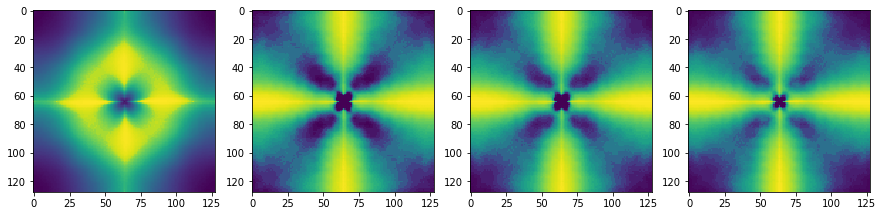

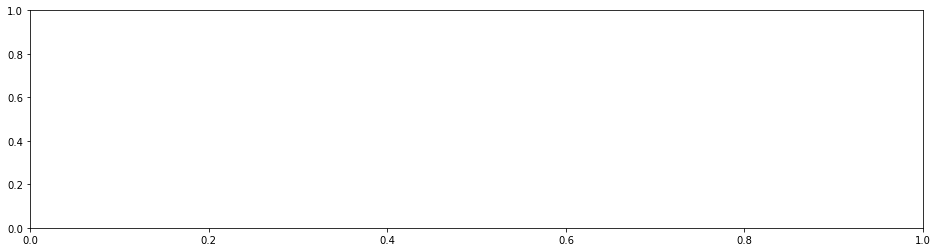

iPhone-4s: 100%|█████████████████████████████████████████████████████████████████████| 275/275 [05:28<00:00,  1.19s/it]


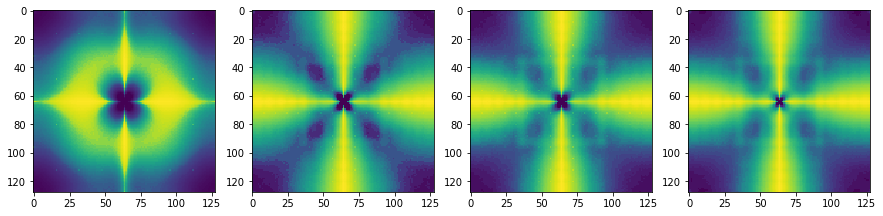

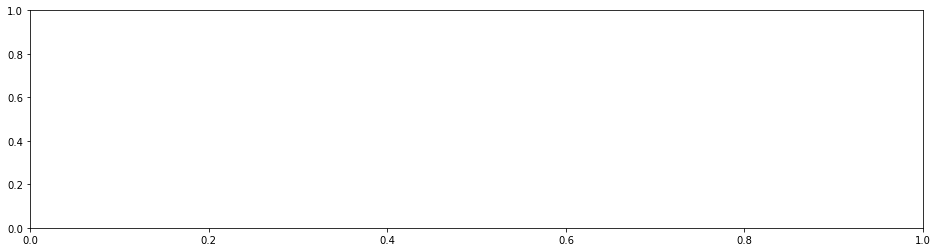

iPhone-6: 100%|██████████████████████████████████████████████████████████████████████| 275/275 [05:29<00:00,  1.20s/it]


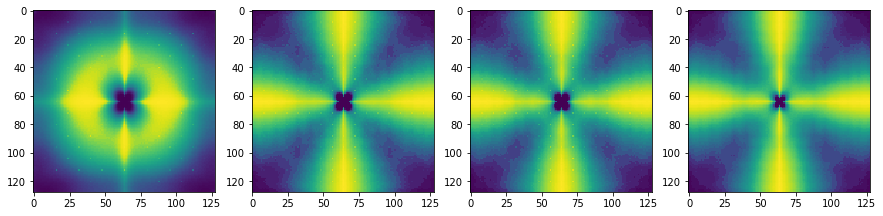

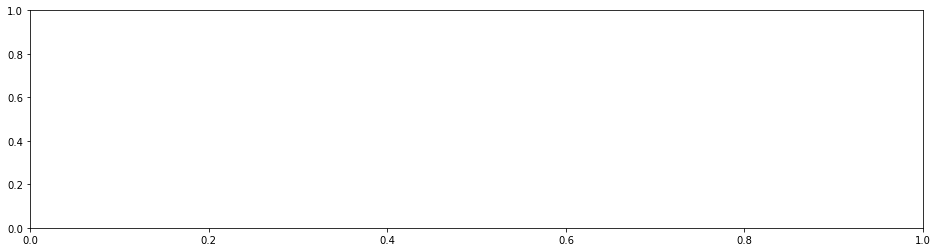

LG-Nexus-5x: 100%|███████████████████████████████████████████████████████████████████| 272/272 [05:46<00:00,  1.28s/it]


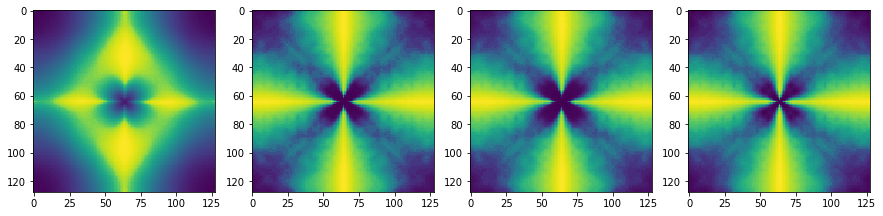

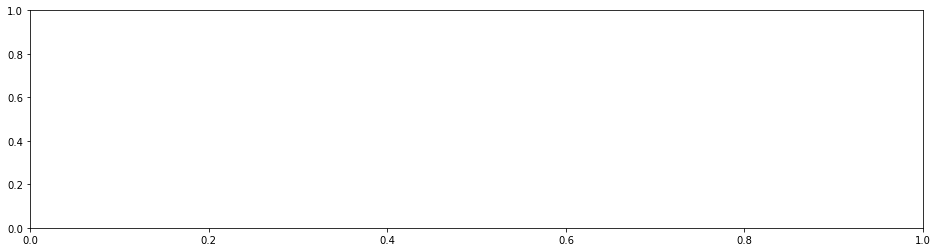

Motorola-Droid-Maxx: 100%|███████████████████████████████████████████████████████████| 236/236 [05:10<00:00,  1.32s/it]


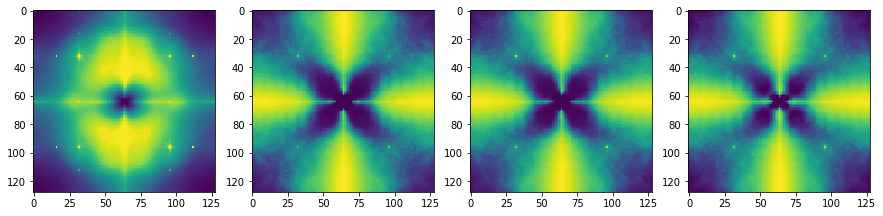

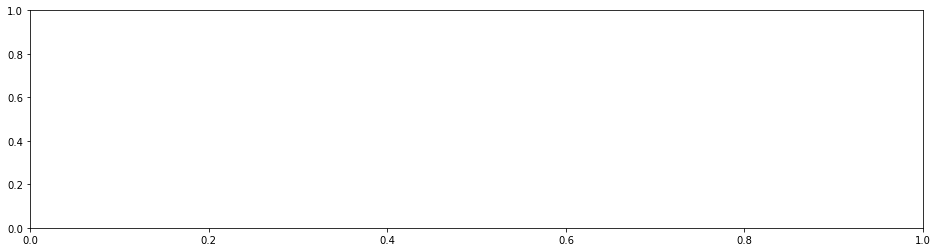

Motorola-Nexus-6: 100%|██████████████████████████████████████████████████████████████| 144/144 [03:07<00:00,  1.30s/it]


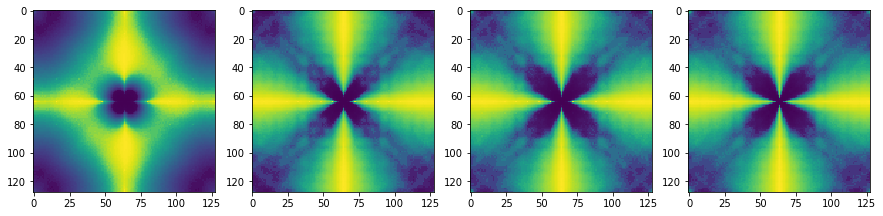

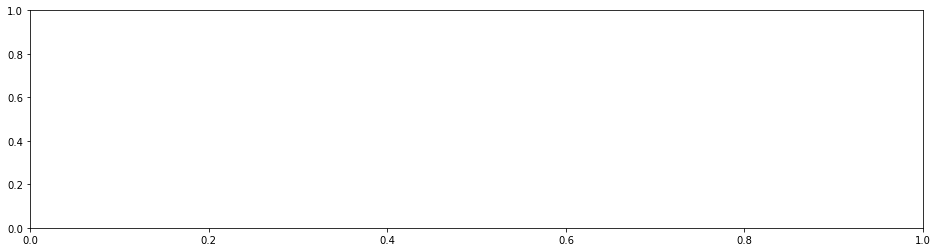

Motorola-X: 100%|████████████████████████████████████████████████████████████████████| 234/234 [05:06<00:00,  1.31s/it]


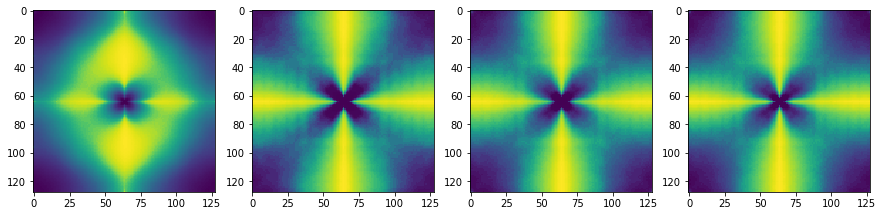

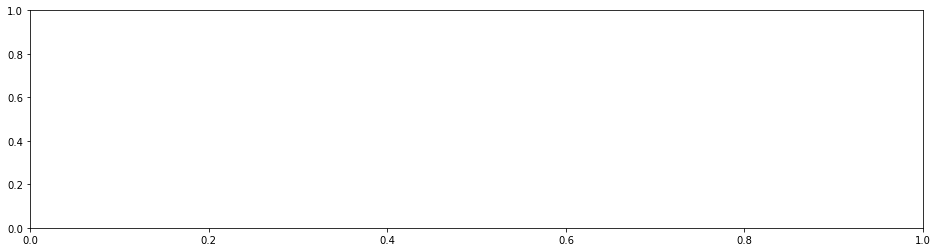

Samsung-Galaxy-Note3: 100%|██████████████████████████████████████████████████████████| 275/275 [05:26<00:00,  1.19s/it]


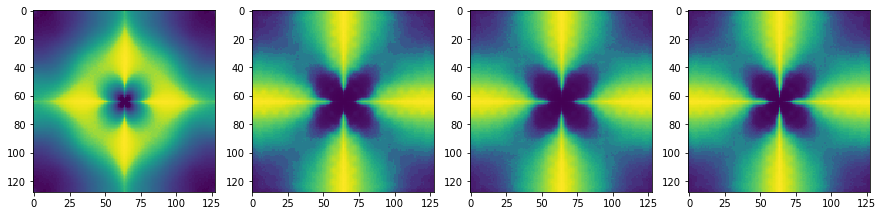

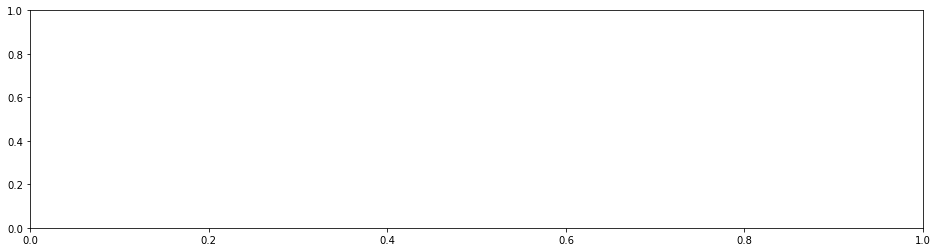

Samsung-Galaxy-S4: 100%|█████████████████████████████████████████████████████████████| 275/275 [05:35<00:00,  1.22s/it]


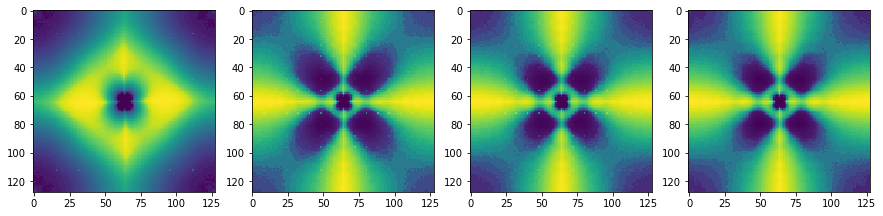

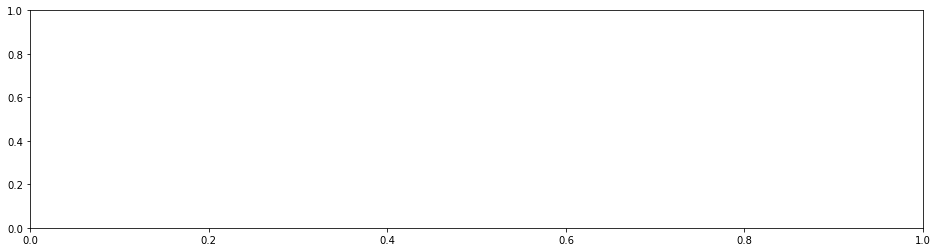

Sony-NEX-7: 100%|████████████████████████████████████████████████████████████████████| 275/275 [07:28<00:00,  1.63s/it]


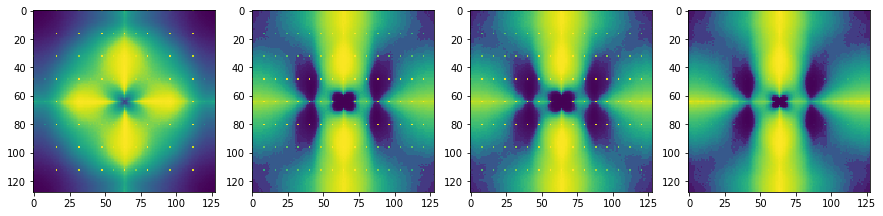

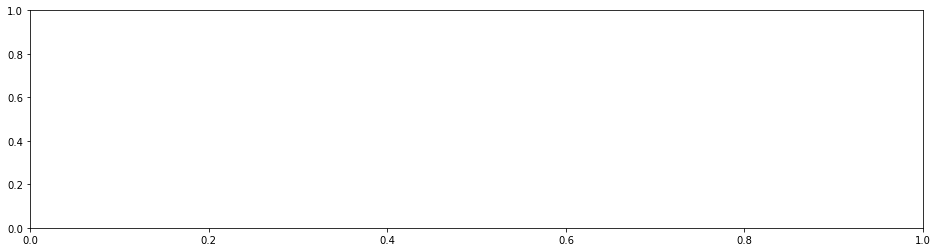

In [81]:
plot_all_model_features(W=128)

In [ ]:
#Preprocessing
cat_encoder = preprocessing.LabelEncoder()
cat_encoder.fit(train['camera'])
nclass = cat_encoder.classes_.shape[0]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(24,24))
def imread_and_normalize(im_path):
    img_data = imread(im_path)
    img_data = cv2.cvtColor(img_data[:,:,[2,1,0]],cv2.COLOR_BGR2LAB)
    img_data[:,:,0] = clahe.apply(img_data[:,:,0])
    img_data = cv2.cvtColor(img_data, cv2.COLOR_LAB2BGR)
    
    return (img_data.astype(np.float32))/255.0

In [ ]:
%%time
def read_chunk(im_path, n_chunk = 5, chunk_x = 96, chunk_y=96):
    img_data = imread_and_normalize(im_path)
    img_x, img_y, _ = img_data.shape
    out_chunk = []
    for _ in range(n_chunk):
        x_pos = np.random.choice(range(img_x-chunk_x))
        y_pos = np.random.choice(range(img_y-chunk_y))
        out_chunk += [img_data[x_pos:(x_pos+chunk_x),y_pos:(y_pos+chunk_y),:3]]
    return np.stack(out_chunk, 0)

t_img=read_chunk(train['path'].values[0])
fig, c_axs = plt.subplots(2, 3, figsize = (12, 4))
for i, (c_ax, m_ax) in enumerate(c_axs.T):
    c_ax.imshow(t_img[0,:,:,i], interpolation='none')
    c_ax.axis('off')
    c_ax.set_title(['Red', 'Green', 'Blue'][i])
    m_ax.hist(t_img[0,:,:,i].ravel())

# Logistic Regression

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

In [ ]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# Use score method to get accuracy of model
score = classifier.score(x_test, y_test)
print(score)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
accScore = metrics.accuracy_score(y_test, y_pred)
classReport = metrics.classification_report(y_test, y_pred)
print(accScore)
print(classReport)

In [ ]:
output = pd.DataFrame(y_pred)
print(output)

# K-Nearest Neighbor

In [ ]:
#Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

In [ ]:
row0 = x_train[0]
for row in x_train:
    distance = euclidean_distance(row0, row)
    print(distance)

In [ ]:
#Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
    distances = list()
    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

In [ ]:
neighbors = get_neighbors(x_train, x_train[0], 3)
for neighbor in neighbors:
    print(neighbor)

In [ ]:
#Make a classification prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
    neighbors = get_neighbors(train, test_row, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

In [ ]:
prediction = predict_classification(x_train, x_train[0], 3)
print('Expected %d, Got %d.' %(x_train[0][-1],prediction))

In [ ]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_train,Y_train,test_size=.25,random_state=1)
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(x_train, y_train)

In [ ]:
y_pred_knn = knn.predict(x_test)

In [ ]:
metrics.confusion_matrix(y_test_knn, y_pred_knn)
output_knn = pd.DataFrame(y_pred_knn)
score = metrics.accuracy_score(y_test_knn, y_pred_knn)
print(output_knn)
print(score)

In [ ]:
output_knn.describe()

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(x_train, y_train)

In [ ]:
KNN_prediction = KNN_model.predict(x_test)

In [ ]:
print(metrics.accuracy_score(KNN_prediction, y_test))

In [ ]:
print(metrics.classification_report(KNN_prediction, y_test))

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=1)
KNN_model.fit(x_train, y_train)
KNN_prediction = KNN_model.predict(x_test)
print(metrics.accuracy_score(KNN_prediction, y_test))

In [ ]:
print(metrics.classification_report(KNN_prediction, y_test))

In [ ]:
output_knn2 = pd.DataFrame(KNN_prediction)
print(output_knn2)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_Classifier = DecisionTreeClassifier()
dt_Classifier.fit(x_train, y_train)

In [ ]:
dt_y_pred = dt_Classifier.predict(x_test)

In [ ]:
print(metrics.confusion_matrix(y_test, dt_y_pred))
print(metrics.classification_report(y_test, dt_y_pred))

In [ ]:
output_dt = pd.DataFrame(dt_y_pred)
print(output_dt)

# Model Comparison

In [ ]:
#Plot accuracy of each model 
x_score = ['Logistic', 'KNN=5', 'KNN=1', 'Decision Tree']
y_score = [.80, .60, .64, .72]

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
plt.rcParams["figure.figsize"] = fig_size
plt.plot(x_score,y_score, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)